In [ ]:
# This is an example GPT style decoder only transformer model and example dataset
# This an example of the use of the icanswim/cosmosis repo for data science and 
# machine learning projects

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from cosmosis.dataset import AsTensor
from cosmosis.learning import Learn, Selector, Metrics
from cosmosis.model import GPT

from dataset import TinyShakes

In [2]:
# explore the ds

ds_param = {'transforms': {'tokens': [AsTensor()],
                           'y': [AsTensor()],
                           'position': [AsTensor()]},
            'd_seq': 10,
            'n': 1}

ts = TinyShakes(**ds_param)

print(ts[0])
print(ts[0]['tokens'].shape, ts[0]['tokens'].dtype)
print(ts[0]['y'].shape, ts[0]['y'].dtype)
print('decoded tokens: ', ts.encoding.decode(ts[0]['tokens'].tolist()))
print('decoded y: ', ts.encoding.decode(ts[0]['y'].tolist()))

tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyskakes_encoded.bin
len(self.ds_idx):  1
data.nbytes:  676050
CDataset created...
{'tokens': tensor([ 5962, 22307,    25,   198,  8421,   356,  5120,   597,  2252,    11]), 'y': tensor([22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,  3285]), 'position': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}
torch.Size([10]) torch.int64
torch.Size([10]) torch.int64
decoded tokens:  First Citizen:
Before we proceed any further,
decoded y:   Citizen:
Before we proceed any further, hear


In [3]:
# example using prompt for inference

ds_param = {'transforms': {'tokens': [AsTensor()],
                           'y': [AsTensor()],
                           'position': [AsTensor()]},
            'd_seq': 10,
            'prompt': 'All the worlds a stage and all the men and women merely'}

prompt = TinyShakes(**ds_param)
print(prompt[0])
print(prompt[0]['tokens'].shape)
print(prompt[0]['y'].shape)
print('decoded tokens: ', ts.encoding.decode(prompt[0]['tokens'].tolist()))
print('decoded y: ', ts.encoding.decode(prompt[0]['y'].tolist()))

len(self.ds_idx):  1
data.nbytes:  24
CDataset created...
{'tokens': tensor([ 3237,   262, 11621,   257,  3800,   290,   477,   262,  1450,   290]), 'y': tensor([  262, 11621,   257,  3800,   290,   477,   262,  1450,   290,  1466]), 'position': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}
torch.Size([10])
torch.Size([10])
decoded tokens:  All the worlds a stage and all the men and
decoded y:   the worlds a stage and all the men and women


In [4]:
# pass a single example from dataset to model to loss function
# (batch, d_seq, d_model)

d_seq = 10 # dimension sequence
d_vocab = 50304 # dimension vocabulary
d_vec = 32 # dimension embedding vector
d_model = 32 # dimension model input
assert d_model == d_vec

ds_param = {'transforms': {'tokens': [AsTensor()],
                           'y': [AsTensor()],
                           'position': [AsTensor()]},
            'd_seq': d_seq,
            'prompt': 'All the worlds a stage and all the men and women merely'}

prompt = TinyShakes(**ds_param)
print(prompt[0])
print(prompt[0]['tokens'].shape)
print(prompt[0]['y'].shape)
print(prompt[0]['position'].shape)
print('decoded tokens: ', prompt.encoding.decode(prompt[0]['tokens'].tolist()))
print('decoded y tokens: ', prompt.encoding.decode(prompt[0]['y'].tolist()))

model_param = {'device': 'cpu',
               'd_model': d_model, # matches embedding dimension
               'd_vocab': d_vocab, 
               'n_head': 2, 
               'num_layers': 2,
               'd_seq': d_seq,
               'd_vec': d_vec,
               'embed_param': {'tokens': (d_vocab, d_vec, None, True), 
                               'y': (d_vocab, d_vec, None, True),
                               'position': (d_seq, d_vec, None, True)}} 

gpt = GPT(model_param)

data = prompt[0]
out = gpt(data)
print('output: ', out, out.shape, out.dtype)

prompt_tokens = data['tokens']
print('prompt_tokens: ', prompt_tokens, prompt_tokens.shape, prompt_tokens.dtype)

target_tokens = data['y']
print('target_tokens: ', target_tokens, target_tokens.shape, target_tokens.dtype)

generated_tokens = out.squeeze()
print('generated_tokens: ', generated_tokens, generated_tokens.shape, generated_tokens.dtype)
print('decoded generated tokens: ', prompt.encoding.decode(generated_tokens.argmax(dim=-1).tolist()))

cel_func = CrossEntropyLoss()
loss = cel_func(out, target_tokens)
print('loss: ', loss)


len(self.ds_idx):  1
data.nbytes:  24
CDataset created...
{'tokens': tensor([ 3237,   262, 11621,   257,  3800,   290,   477,   262,  1450,   290]), 'y': tensor([  262, 11621,   257,  3800,   290,   477,   262,  1450,   290,  1466]), 'position': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}
torch.Size([10])
torch.Size([10])
torch.Size([10])
decoded tokens:  All the worlds a stage and all the men and
decoded y tokens:   the worlds a stage and all the men and women
applying _init_weights...
GPT model loaded...
output:  tensor([[ 0.0380, -0.2468, -0.0829,  ..., -0.1061, -0.1831, -0.2107],
        [ 0.1738,  0.0505, -0.0460,  ..., -0.0528,  0.1039,  0.0640],
        [-0.0150, -0.0223,  0.1233,  ..., -0.0501,  0.0132,  0.0056],
        ...,
        [ 0.0621,  0.0034, -0.0744,  ..., -0.0550, -0.1429,  0.0168],
        [ 0.1444, -0.1619, -0.0849,  ...,  0.1433,  0.1019,  0.0666],
        [ 0.0664, -0.0544,  0.0531,  ...,  0.0121, -0.1116, -0.3077]],
       grad_fn=<MmBackward0>) torch.Size([10, 503

tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyskakes_encoded.bin
len(self.ds_idx):  337925
data.nbytes:  676050
CDataset created...
applying _init_weights...
GPT model loaded...
running model on gpu...

.....................

total elapsed time: 0:59:29.764249
epoch: 1
y_pred:  m chiefly cheat thrown harmless laid Power muff adjacent ProvprisonAR spectators:' blades unm huntedaded men instinct Fiveh judgement conveniently scarcely Silvernam grayward Pad Buckingham Irish happierHer yields disorderly thrust amaz stead rot divorcedopp hung constantly regenerate Thusrors busraiseensedals Imadvant accuser rhy eloqu man prescription rooting depending observe int enrolledPost occupations greetsienceency swallowed stag mun worriesinguabel followerscies Serving musicians derived consec severely passedfully Berm Spanishbilstachers argues prol Creator sh beware Cr supremacy ScDist demanded Marvol
y:  And bring away the armour that is there.
Gentlemen, wi

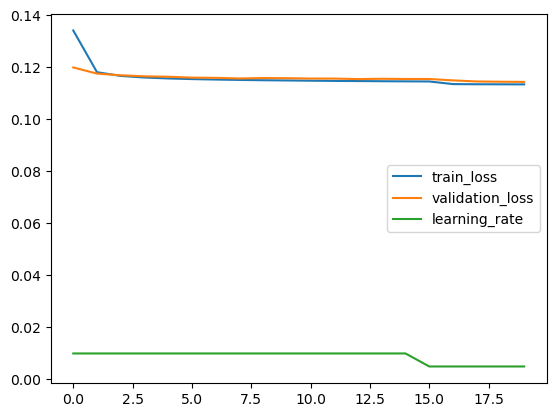

In [2]:
# put all together in a learner
# (batch, d_seq, d_model)

d_seq = 100 # dimension sequence
d_vocab = 50304 # dimension vocabulary
d_vec = 512 # dimension embedding vector
d_model = 512 # dimension model input
assert d_model == d_vec

ds_param = {'train_param': {'transforms': {'tokens': [AsTensor()],
                            'y': [AsTensor()],
                            'position': [AsTensor()]},
            'd_seq': d_seq,
            #'n': 100000
                           }}

model_param = {'gpu': True,
               'd_model': d_model,
               'd_vocab': d_vocab, 
               'n_head': 8, 
               'num_layers': 6,
               'd_seq': d_seq,
               'd_vec': d_vec,
               'embed_param': {'tokens': (d_vocab, d_vec, None, True), 
                               'y': (d_vocab, d_vec, None, True),
                               'position': (d_seq, d_vec, None, True)}} 
                                       
metrics_param = {'metric_name': 'transformer',
                 'report_interval': 1,
                 'log_plot': False,
                 'min_lr': .0025} # break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=32, epochs=20, gpu=True, 
              save_model='gpt_test_model', load_model=None,
              target='y')

In [2]:
# inference
ds_param = {'train_param': {'transforms': {'X1': [AsTensor()],
                                           'X2': [AsTensor()]},
                            'd_seq': 10,
                            'prompt': 'All the worlds a stage and all the men and women merely'}}

model_param = {'device': 'cuda',
               'd_model': 32, # matches embedding dimension
               'd_vocab': 50304, # matches embedding vocab
               'n_head': 4, 
               'num_layers': 3,
               'linear_head': True,
               'probs': False,
               'tokens': False,
               'transpose': True, 
               'embed_param': {'X1': (50304, 32, None, True),
                               'X2': (50304, 32, None, True)}} 

                                       
metrics_param = {'metric_name': 'transformer',
                 'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .005} # break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=None,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=1, epochs=10, gpu=True, 
              load_model='gpt_test_model.pth', target='y')


len(self.ds_idx):  1
data.nbytes:  24
CDataset created...
CModel loaded...
model loaded from state_dict...
running model on gpu...
data1:  {'X1': tensor([[ 3237,   262, 11621,   257,  3800,   290,   477,   262,  1450,   290]],
       device='cuda:0'), 'X2': tensor([[  262, 11621,   257,  3800,   290,   477,   262,  1450,   290,  1466]],
       device='cuda:0')}
data1:  {'X1': tensor([[ 3237,   262, 11621,   257,  3800,   290,   477,   262,  1450,   290]],
       device='cuda:0'), 'X2': tensor([[  262, 11621,   257,  3800,   290,   477,   262,  1450,   290,  1466]],
       device='cuda:0')}
data:  tensor([ 258,  979,  425,  323, 2367, 2984, 1272, 3382,   84, 5975],
       device='cuda:0')


IndexError: tuple index out of range